In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

import glob, os, pathlib
import read_summary

# Set some default properties
mpl.rcParams['savefig.dpi'] = 1000
mpl.rcParams['font.family'] = "Arial"

# Make figures dir
if not pathlib.Path('./figures').exists():
    os.mkdir('./figures')

# Create a dataframe and units dict from any result summary files found:
pattern = './runs/*/result_summary.txt'
results, units = read_summary.df_from_pattern(pattern)
print('Loaded %i result files.' % len(results))
print('Columns/units:')
print(units)
print()

loading ./runs/panasas-1-1-300-0-POSIX/result_summary.txt
loading ./runs/panasas-1-2-300-0-POSIX/result_summary.txt
loading ./runs/quobyte-1-1-300-0-POSIX/result_summary.txt
loading ./runs/quobyte-1-2-300-0-POSIX/result_summary.txt
loading ./runs/panasas-1-4-300-0-POSIX/result_summary.txt
loading ./runs/quobyte-1-4-300-0-POSIX/result_summary.txt
loading ./runs/panasas-1-16-300-0-POSIX/result_summary.txt
loading ./runs/quobyte-1-16-300-0-POSIX/result_summary.txt
loading ./runs/panasas-2-2-300-0-POSIX/result_summary.txt
loading ./runs/quobyte-2-2-300-0-POSIX/result_summary.txt
loading ./runs/panasas-10-2-300-0-POSIX/result_summary.txt
loading ./runs/quobyte-10-2-300-0-POSIX/result_summary.txt
loading ./runs/panasas-1-1-300-1-POSIX/result_summary.txt
loading ./runs/panasas-1-1-300-2-POSIX/result_summary.txt
loading ./runs/quobyte-1-1-300-1-POSIX/result_summary.txt
loading ./runs/quobyte-1-1-300-2-POSIX/result_summary.txt
loading ./runs/panasas-1-2-300-1-POSIX/result_summary.txt
loading ./

In [2]:
# Characterise columns as bandwidth, IOPs, or descriptive:
print('all columns:', list(results.columns))
bw_unit = 'GiB/s'
iops_unit = 'kIOPS'
score_cols = [c for c, u in units.items() if 'score' in c]
print('score_cols:', score_cols)
descr_cols = [c for c, u in units.items() if (u is None and 'score' not in c)]
print('descr_cols:', descr_cols)
bw_cols = [c for c, u in units.items() if (u == bw_unit and 'score' not in c)]
print('bw_cols:', bw_cols)
iops_cols = [c for c, u in units.items() if (u == iops_unit and 'score' not in c)]
print('iops_cols:', iops_cols)
result_cols = bw_cols + iops_cols + score_cols
print('result_cols:', result_cols)
metric_names = {
    bw_unit: 'Bandwidth',
    iops_unit: 'IOPs',
}

all columns: ['nodes', 'ntasks_per_node', 'filesystem.name', 'filesystem.mountpoint', 'stonewall', 'iters', 'time', 'ior_api', 'ior-easy-write', 'mdtest-easy-write', 'ior-hard-write', 'mdtest-hard-write', 'find', 'ior-easy-read', 'mdtest-easy-stat', 'ior-hard-read', 'mdtest-hard-stat', 'mdtest-easy-delete', 'mdtest-hard-read', 'mdtest-hard-delete', 'bandwidth-score', 'iops-score', 'total-score']
score_cols: ['bandwidth-score', 'iops-score', 'total-score']
descr_cols: ['nodes', 'ntasks_per_node', 'filesystem.name', 'filesystem.mountpoint', 'stonewall', 'iters', 'time', 'ior_api']
bw_cols: ['ior-easy-write', 'ior-hard-write', 'ior-easy-read', 'ior-hard-read']
iops_cols: ['mdtest-easy-write', 'mdtest-hard-write', 'find', 'mdtest-easy-stat', 'mdtest-hard-stat', 'mdtest-easy-delete', 'mdtest-hard-read', 'mdtest-hard-delete']
result_cols: ['ior-easy-write', 'ior-hard-write', 'ior-easy-read', 'ior-hard-read', 'mdtest-easy-write', 'mdtest-hard-write', 'find', 'mdtest-easy-stat', 'mdtest-hard-s

In [3]:
# produce 2 dataframes with same columns except no 'iters', giving min and max values of results respectively:
def extremum_iters(results):
    """ Given a dataframe with 'iters', return (mins, max) without 'iters' column. """
    
    non_iters_descrs = [d for d in descr_cols if d != 'iters']
    mins = results.groupby(non_iters_descrs).min().reset_index().drop('iters', axis='columns') # reset ditches heirarchical index
    maxs = results.groupby(non_iters_descrs).max().reset_index().drop('iters', axis='columns')
    return (mins, maxs)

In [4]:
# Utilities:
def GiB_to_Gb(val):
    return val * 8*2**30 / 10**9

# POSIX results by Vendor

In [5]:
posix1_results = results.loc[(results['ior_api'] == 'POSIX')]

panasas


,0
ior-easy-write,15.23
ior-hard-write,0.93
ior-easy-read,8.66
ior-hard-read,2.87
mdtest-easy-write,4.81
mdtest-hard-write,2.84
find,1008.59
mdtest-easy-stat,51.88
mdtest-hard-stat,36.31
mdtest-easy-delete,8.77


pure


,0
ior-easy-write,2.87
ior-hard-write,1.36
ior-easy-read,13.43
ior-hard-read,1.65
mdtest-easy-write,82.02
mdtest-hard-write,2.81
find,15.97
mdtest-easy-stat,298.26
mdtest-hard-stat,59.41
mdtest-easy-delete,81.10


quobyte


,0
ior-easy-write,2.75
ior-hard-write,0.44
ior-easy-read,2.14
ior-hard-read,0.83
mdtest-easy-write,3.51
mdtest-hard-write,0.17
find,556.95
mdtest-easy-stat,54.97
mdtest-hard-stat,57.31
mdtest-easy-delete,6.47


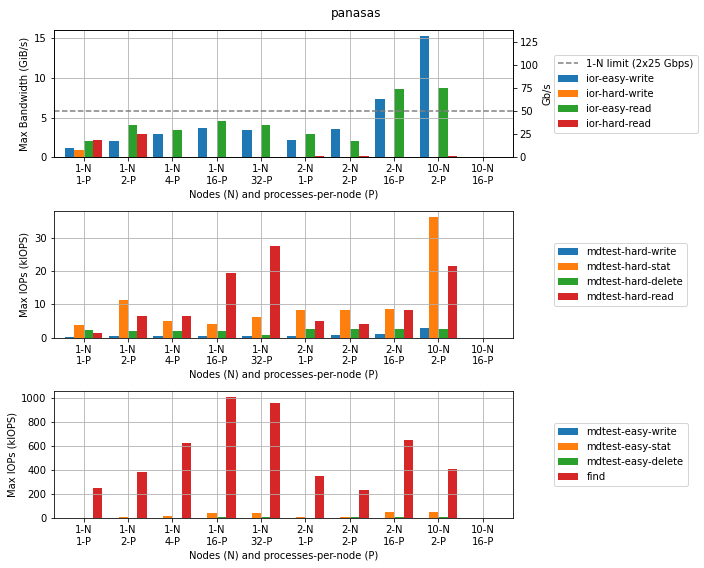

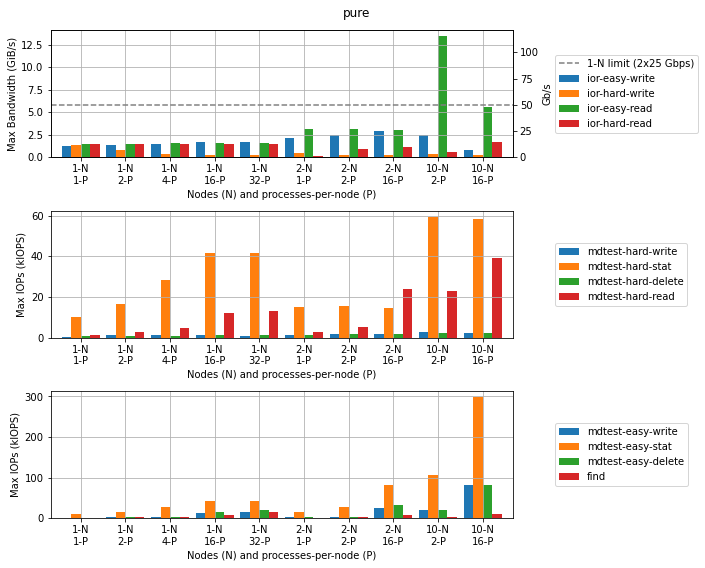

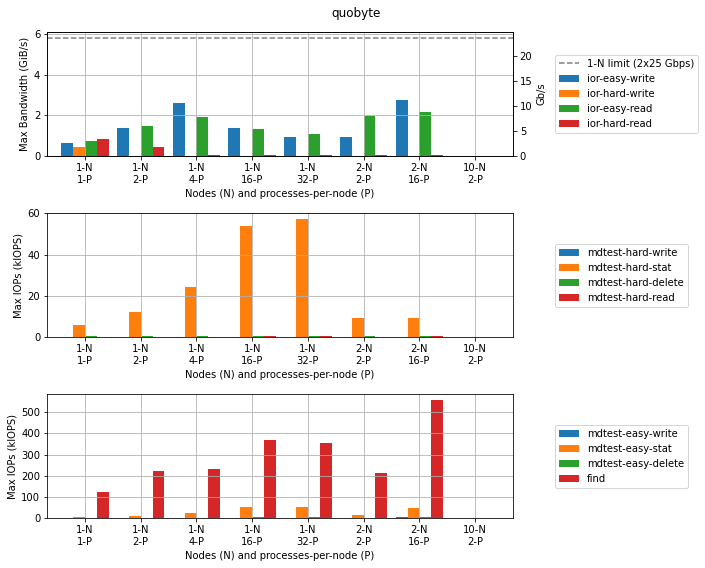

In [12]:
from IPython.display import HTML

# ior-easy-{r,w}, all vendors, single node POSIX
posix1_plots = (
    {
     'ylabel': f'Max Bandwidth ({ bw_unit })',
     'cols': bw_cols,
     # 'yscale': 'symlog',
     # 'ylim': (0, 16),
    },
    {'ylabel': f'Max IOPs ({ iops_unit })',
     'cols': ['mdtest-hard-write', 'mdtest-hard-stat', 'mdtest-hard-delete', 'mdtest-hard-read'],
     # 'yscale': 'symlog',
     # 'ylim': (0, 60),
    },
    {'ylabel': f'Max IOPs ({ iops_unit })',
     'cols': ['mdtest-easy-write', 'mdtest-easy-stat', 'mdtest-easy-delete', 'find'],
     # 'yscale': 'symlog',
     # 'ylim': (0, 1100),
    }
)
width=0.85
for vendor, fs_results in posix1_results.groupby('filesystem.name'):
    print(vendor)
    display(HTML(fs_results[result_cols].max(axis=0).to_frame().style.format('{:.2f}').to_html()))
    fig, axs = plt.subplots(figsize=(10, 8), nrows=len(posix1_plots))
    _, fs_max = extremum_iters(fs_results)
    fs_max.set_index(['nodes', 'ntasks_per_node'], inplace=True)
    
    xlabels = ['%i-N\n%i-P' % (v[0], v[1]) for v in fs_max.index.tolist()] # v = (nodes, ntasks_per_node)

    for ix, plot in enumerate(posix1_plots):
        ax = axs[ix]
        fs_max.plot.bar(ax=ax, y=plot['cols'], grid=True, xlabel='Nodes (N) and processes-per-node (P)', ylabel=plot['ylabel'], width=width)
        ax.set_xticklabels(xlabels, rotation=0)
        axes = [ax]
        if 'ylim' in plot:
            ax.set_ylim(*plot['ylim'])
        if bw_unit in plot['ylabel']:
            ax2 = ax.twinx()
            ax2.set_ylim(tuple(map(GiB_to_Gb, ax.get_ylim())))
            ax2.set_ylabel('Gb/s')
            ax.axhline([50 / (8*2**30 / 10**9)], label='1-N limit (2x25 Gbps)', c='grey', ls='--') # on GiB axis so it gets in legend
            axes.append(ax2)
        if 'yscale' in plot:
            for a in axes:
                a.set_yscale(plot['yscale'])
                if 'log' in plot['yscale']:
                    a.yaxis.set_major_formatter(ScalarFormatter())
        ax.legend(loc='center left',bbox_to_anchor=(1.08, 0.5))
        
    fig.suptitle(vendor)
    fig.tight_layout()
    fig.savefig(f'figures/{vendor}-1node-posix.png')
    

# POSIX vs MPI-IO

In [7]:
_, all_maxes = extremum_iters(results)

# separate data into posix/mpiio:
posix = all_maxes.loc[all_maxes['ior_api'] == 'POSIX']
mpiio = all_maxes.loc[all_maxes['ior_api'] == 'MPIIO']

# merge dataframes on relevant description columns:
api_match_ignore = ['iters', 'ior_api'] # have to omit iters, as that's already gone from the mins and maxs dfs
api_match_cols = [d for d in descr_cols if d not in api_match_ignore]
merged = pd.merge(posix, mpiio, on=api_match_cols, suffixes=('_posix', '_mpiio'))

# change colums to contain the DELTA between matching POSIX/MPIIO rows:
for col in result_cols:
    merged[col] = merged[col+'_posix'] - merged[col+'_mpiio']
    merged.drop(col+'_posix', axis='columns', inplace=True)
    merged.drop(col+'_mpiio', axis='columns', inplace=True)
merged.drop(['ior_api_posix', 'ior_api_mpiio'], axis='columns', inplace=True)

# change to a multi level index to allow easy grouped plotting:
merged.set_index(api_match_cols, inplace=True)

# create separate Bandwidth and IOPs dataframes:
merged_bw = merged[bw_cols]
merged_iops = merged[iops_cols]

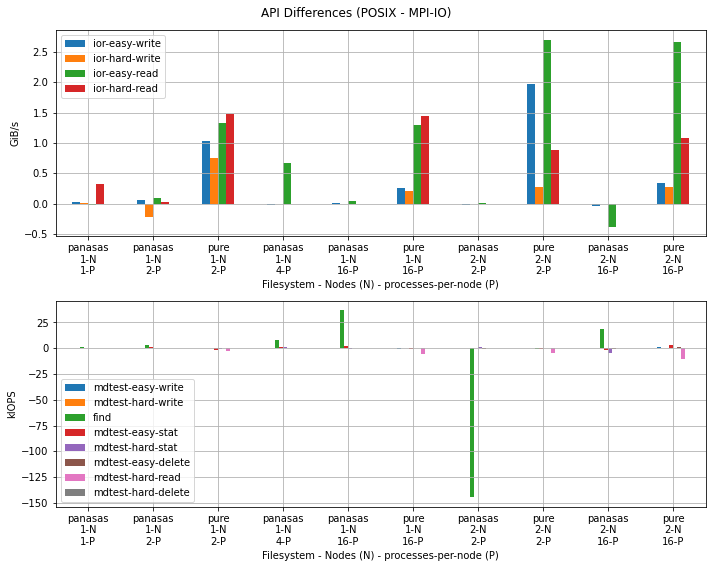

In [8]:
# create a set of labels from the multi-index:
plot_index = merged.index.droplevel(['filesystem.mountpoint', 'stonewall', 'time'])
xlabels = [f'{ v[2] }\n{ v[0] }-N\n{ v[1] }-P' for v in plot_index.tolist()]
xlabel = 'Filesystem - Nodes (N) - processes-per-node (P)'

fig, axs = plt.subplots(nrows=2)
bw_ax = merged_bw.plot.bar(ax=axs[0], y=bw_cols, figsize=(20, 4), grid=True,xlabel=xlabel, ylabel=bw_unit)
iops_ax= merged_iops.plot.bar(ax=axs[1], y=iops_cols, figsize=(20, 4), grid=True,xlabel=xlabel, ylabel=iops_unit)
bw_ax.set_xticklabels(xlabels, rotation=0)
iops_ax.set_xticklabels(xlabels, rotation=0)

fig.suptitle('API Differences (POSIX - MPI-IO)')
fig.set_size_inches(10, 8)
fig.tight_layout()
fig.savefig(f'figures/mpiio.png')

# Cross-vendor POSIX Summary

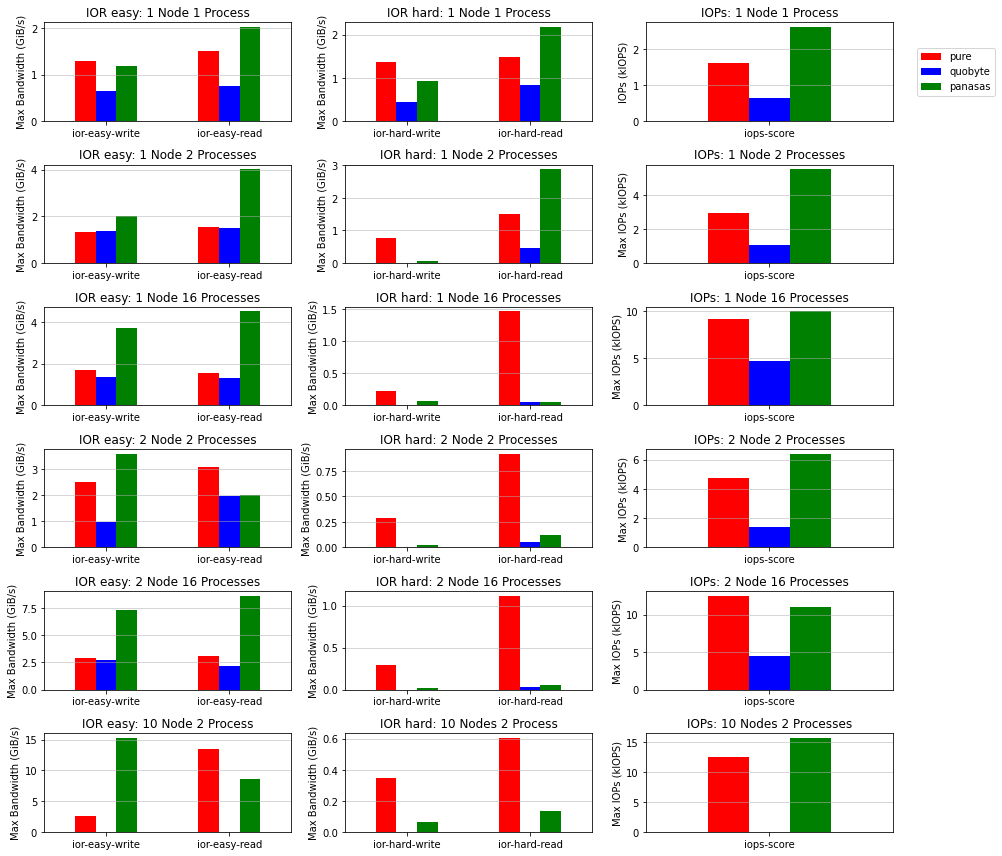

In [9]:
_, max_posix = extremum_iters(results.loc[(results['ior_api'] == 'POSIX')])

xvendor_plots = (
    # 1x nodes, 1x process
    {
        'subplot': (0, 0),
        'title': 'IOR easy: 1 Node 1 Process',
        'cols': [c for c in result_cols if 'ior-easy' in c],
        'ylabel': f'Max Bandwidth ({bw_unit})',
        'nodes': 1,
        'ntasks_per_node': 1,
    },
    {
        'subplot': (0, 1),
        'title': 'IOR hard: 1 Node 1 Process',
        'cols': [c for c in result_cols if 'ior-hard' in c],
        'ylabel': f'Max Bandwidth ({bw_unit})',
        'nodes': 1,
        'ntasks_per_node': 1,
    },
    {
        'subplot': (0, 2),
        'title': 'IOPs: 1 Node 1 Process',
        'cols': ['iops-score'],
        'ylabel': f'IOPs ({iops_unit})',
        'nodes': 1,
        'ntasks_per_node': 1,
        # 'rot': None,
        # 'logy': True,
    },
    # 1x nodes, 2x processes
    {
        'subplot': (1, 0),
        'title': 'IOR easy: 1 Node 2 Processes',
        'cols': [c for c in result_cols if 'ior-easy' in c],
        'ylabel': f'Max Bandwidth ({bw_unit})',
        'nodes': 1,
        'ntasks_per_node': 2,
    },
    {
        'subplot': (1, 1),
        'title': 'IOR hard: 1 Node 2 Processes',
        'cols': [c for c in result_cols if 'ior-hard' in c],
        'ylabel': f'Max Bandwidth ({bw_unit})',
        'nodes': 1,
        'ntasks_per_node': 2,
    },
    {
        'subplot': (1, 2),
        'title': 'IOPs: 1 Node 2 Processes',
        'cols': ['iops-score'],
        'ylabel': f'Max IOPs ({iops_unit})',
        'nodes': 1,
        'ntasks_per_node': 2,
        # 'rot': None,
        # 'logy': True,
    },
    # 1x nodes, 16x processes
    {
        'subplot': (2, 0),
        'title': 'IOR easy: 1 Node 16 Processes',
        'cols': [c for c in result_cols if 'ior-easy' in c],
        'ylabel': f'Max Bandwidth ({bw_unit})',
        'nodes': 1,
        'ntasks_per_node': 16,
    },
    {
        'subplot': (2, 1),
        'title': 'IOR hard: 1 Node 16 Processes',
        'cols': [c for c in result_cols if 'ior-hard' in c],
        'ylabel': f'Max Bandwidth ({bw_unit})',
        'nodes': 1,
        'ntasks_per_node': 16,
    },
    {
        'subplot': (2, 2),
        'title': 'IOPs: 1 Node 16 Processes',
        'cols': ['iops-score'],
        'ylabel': f'Max IOPs ({iops_unit})',
        'nodes': 1,
        'ntasks_per_node': 16,
        # 'rot': None,
        # 'logy': True,
    },
    # 2x nodes, 2x processes
    {
        'subplot': (3, 0),
        'title': 'IOR easy: 2 Node 2 Processes',
        'cols': [c for c in result_cols if 'ior-easy' in c],
        'ylabel': f'Max Bandwidth ({bw_unit})',
        'nodes': 2,
        'ntasks_per_node': 2,
    },
    {
        'subplot': (3, 1),
        'title': 'IOR hard: 2 Node 2 Processes',
        'cols': [c for c in result_cols if 'ior-hard' in c],
        'ylabel': f'Max Bandwidth ({bw_unit})',
        'nodes': 2,
        'ntasks_per_node': 2,
    },
    {
        'subplot': (3, 2),
        'title': 'IOPs: 2 Node 2 Processes',
        'cols': ['iops-score'],
        'ylabel': f'Max IOPs ({iops_unit})',
        'nodes': 2,
        'ntasks_per_node': 2,
        # 'rot': None,
        # 'logy': True,
    },
    
    # 2x nodes, 16x processes
    {
        'subplot': (4, 0),
        'title': 'IOR easy: 2 Node 16 Processes',
        'cols': [c for c in result_cols if 'ior-easy' in c],
        'ylabel': f'Max Bandwidth ({bw_unit})',
        'nodes': 2,
        'ntasks_per_node': 16,
    },
    {
        'subplot': (4, 1),
        'title': 'IOR hard: 2 Node 16 Processes',
        'cols': [c for c in result_cols if 'ior-hard' in c],
        'ylabel': f'Max Bandwidth ({bw_unit})',
        'nodes': 2,
        'ntasks_per_node': 16,
    },
    {
        'subplot': (4, 2),
        'title': 'IOPs: 2 Node 16 Processes',
        'cols': ['iops-score'],
        'ylabel': f'Max IOPs ({iops_unit})',
        'nodes': 2,
        'ntasks_per_node': 16,
        # 'rot': None,
        # 'logy': True,
    },
    # 4th row: 10x nodes, 2x processes
    {
        'subplot': (5, 0),
        'title': 'IOR easy: 10 Node 2 Process',
        'cols': [c for c in result_cols if 'ior-easy' in c],
        'ylabel': f'Max Bandwidth ({bw_unit})',
        'nodes': 10,
        'ntasks_per_node': 2,
    },
    {
        'subplot': (5, 1),
        'title': 'IOR hard: 10 Nodes 2 Process',
        'cols': [c for c in result_cols if 'ior-hard' in c],
        'ylabel': f'Max Bandwidth ({bw_unit})',
        'nodes': 10,
        'ntasks_per_node': 2,
    },
    {
        'subplot': (5, 2),
        'title': 'IOPs: 10 Nodes 2 Processes',
        'cols': ['iops-score'],
        'ylabel': f'Max IOPs ({iops_unit})',
        'nodes': 10,
        'ntasks_per_node': 2,
        # 'rot': None,
        # 'logy': True,
    },
)


bar_colors={'pure':'r', 'quobyte':'b', 'panasas':'g'} # to match warp-s3 results

nrows = max(plot['subplot'][0] for plot in xvendor_plots) + 1
ncols = max(plot['subplot'][1] for plot in xvendor_plots) + 1
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 12))

for plot in xvendor_plots:
    ax = axs[plot['subplot']]
    # extract appropriate results:
    xvendor_subset = max_posix.loc[(max_posix['nodes'] == plot['nodes']) & (max_posix['ntasks_per_node'] == plot['ntasks_per_node'])]
    
    # to group by read/write we need to turn the df round:
    ior = xvendor_subset[ ['filesystem.name'] + plot['cols'] ]
    ior = ior.set_index('filesystem.name').transpose()[bar_colors.keys()]
    # display(ior)
    has_legend = plot['subplot'] == (0, ncols-1)
    ax = ior.plot.bar(ax=ax, title=plot['title'], color=bar_colors.values(), ylabel=plot['ylabel'], rot=plot.get('rot', 0), logy=plot.get('logy', False), legend=has_legend)
    if plot.get('logy', False):
        ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.grid(axis='y', lw=0.5, zorder=0)
    if has_legend:
        ax.legend(loc='center left',bbox_to_anchor=(1.08, 0.5))

fig.tight_layout()
fig.savefig(f'figures/xvendor-summary.png')
# display(min_posix_1n1p[ min_descr_cols + ior_hard_cols ])
# for fs, fs_results in xvendor_1n.groupby('filesystem.name'):
#     print(fs)
#     display(fs_results)



In [10]:
results.loc[(results['nodes'] == 10) & (results['filesystem.name'] == 'pure') & (results['ntasks_per_node'] == 2)].transpose()

,99,102,103
nodes,10,10,10
ntasks_per_node,2,2,2
filesystem.name,pure,pure,pure
filesystem.mountpoint,/work/stackhpc-pure/,/work/stackhpc-pure/,/work/stackhpc-pure/
stonewall,300,300,300
iters,0,1,2
time,4:0:0,4:0:0,4:0:0
ior_api,POSIX,POSIX,POSIX
ior-easy-write,2.523238,1.878575,0.706425
mdtest-easy-write,19.340158,19.51719,19.03769
